### 3. Hierarchical models and multiple comparisons:

(a) Reproduce the computations in Section 5.5 for the educational testing example. Use the posterior simulations to estimate 

   (i) for each school j, the probability that its coaching program is the best of the eight; and 
    
   (ii) for each pair of schools, j and k, the probability that the coaching program in school j is better than that in school k.

(b) Repeat (a), but for the simpler model with τ set to ∞ (that is, separate estimation for the eight schools). In this case, the probabilities (ii) can be computed analytically.

(c) Discuss how the answers in (a) and (b) differ.

(d) In the model with τ set to 0, the probabilities (i) and (ii) have degenerate values; what are they?

(a) We use the normal model presented in Section 5.4:

Posterior distribution for $\tau$ is given in equation (5.21):

$P(\tau|y) \propto P(\tau)V_\mu^{1/2}\Pi_{j=1}^{J}(\sigma_j^2+\tau^2)^{-1/2}\exp\left(-\frac{(\bar{y}_{.j}-\hat{\mu})^{2}}{2(\sigma_j^2+\tau^2)}\right)$,

where

$\hat{\mu} = \frac{\sum_{j=1}^{J}\frac{1}{\sigma_j^2+\tau^2}\bar{y_{.j}}}{\sum_{j=1}^{J}\frac{1}{\sigma_j^2+\tau^2}}$,

$V_{\mu}^{-1} = \sum_{j=1}^{J}\frac{1}{\sigma_{j}^2+\tau^2}$.


To simulate $\tau$ we use the inverse CDF method, described in Section 1.9, on a uniformly-spaced grid of values of $\tau$:



In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [12]:
%matplotlib inline

In [30]:
# We first get an unnormalized posterior PDF for 0 < tau < 10
# assuming a flat prior
x = np.linspace(0., 30., 1000)

In [31]:
def logtau_postr_dens(t, sigjs, yjs):
    def getmuhat(t, sigjs, yjs):
        muhat = 0.
        for ii, sigj in enumerate(sigjs):
            muhat += yjs[ii]/(sigj**2.+t**2.)
        muhat = muhat / getVmuinv(sigjs, t)
        return muhat
    def getVmuinv(sigjs, t):
        Vmuinv = 0.
        for sigj in sigjs:
            Vmuinv += 1./(sigj**2.+t**2.)
        return Vmuinv
    muhat = getmuhat(t, sigjs, yjs)
    logdens = np.log(np.sqrt(1./(getVmuinv(sigjs, t))))
    for ii, sigj in enumerate(sigjs):
        logdens = logdens - np.log(np.sqrt(sigj**2.+t**2.)) + \
          -(yjs[ii]-muhat)**2./(2.*(sigj**2.+t**2.))
    return logdens

In [32]:
yjs = [28., 8., -3., 7., -1., 1., 18., 12.]
sigjs = [15., 10., 16., 11., 9., 11., 10., 18.]

In [33]:
y = np.zeros(x.shape)

In [40]:
y = logtau_postr_dens(x, sigjs, yjs)
taudens = np.exp(y-y.max())

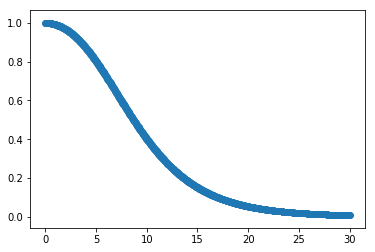

In [41]:
plt.scatter(x, taudens)

In [43]:
# normalize on our grid
taudens = taudens / taudens.sum()

In [47]:
# Approximate the CDF on our grid:
taucdf = np.zeros(taudens.shape)
for ii in range(len(taucdf)):
    taucdf[ii] = sum(taudens[:ii])

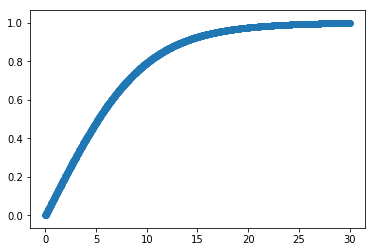

In [48]:
plt.scatter(x, taucdf)

In [76]:
def randomtau(x, taucdf):
    # quick approach
    # return first tau for which a 
    # uniform random is greater than CDF
    U = np.random.uniform()
    tau = x[np.argmax(taucdf > U)]
    return tau

In [84]:
taus = np.zeros(1000)

In [85]:
for ii in range(len(taus)):
    taus[ii] = randomtau(x, taucdf)

(array([ 304.,  277.,  166.,  111.,   64.,   41.,   24.,    6.,    2.,    5.]),
 array([  0.03003003,   2.96696697,   5.9039039 ,   8.84084084,
         11.77777778,  14.71471471,  17.65165165,  20.58858859,
         23.52552553,  26.46246246,  29.3993994 ]),
 <a list of 10 Patch objects>)

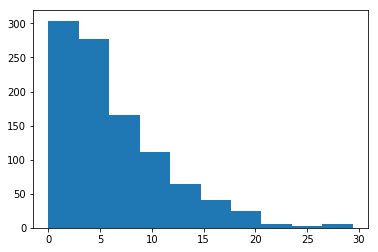

In [87]:
plt.hist(taus)

In [90]:
# simulate the density of mu conditioned on tau:
def randommu(t, sigjs, yjs):
    def getmuhat(t, sigjs, yjs):
        muhat = 0.
        for ii, sigj in enumerate(sigjs):
            muhat += yjs[ii]/(sigj**2.+t**2.)
        muhat = muhat / getVmuinv(sigjs, t)
        return muhat
    def getVmuinv(sigjs, t):
        Vmuinv = 0.
        for sigj in sigjs:
            Vmuinv += 1./(sigj**2.+t**2.)
        return Vmuinv
    muhat = getmuhat(t, sigjs, yjs)
    Vmu = 1./getVmuinv(sigjs, t)
    mu = np.random.normal(loc=muhat, scale=np.sqrt(Vmu))
    return mu

In [91]:
mus = np.zeros(taus.shape)
for ii, tau in enumerate(taus):
    mus[ii] = randommu(tau, sigjs, yjs)

(array([   2.,    8.,   43.,  147.,  313.,  311.,  134.,   30.,   11.,    1.]),
 array([-12.7909827 ,  -8.6800721 ,  -4.56916151,  -0.45825091,
          3.65265968,   7.76357028,  11.87448087,  15.98539147,
         20.09630207,  24.20721266,  28.31812326]),
 <a list of 10 Patch objects>)

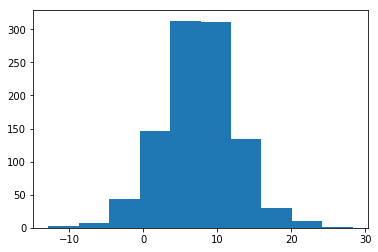

In [93]:
plt.hist(mus)

In [96]:
# simulate the density of the thetas conditioned on mu, tau:
def randomthetas(mu, t, sigjs, yjs):
    def getthetahats(mu, t, sigjs, yjs, Vjs):
        thetahats = np.zeros(len(sigjs))
        for ii, sigj in enumerate(sigjs):
            thetahats[ii] = (yjs[ii]/sigjs[ii]**2.+mu/t**2.)/\
              (1./sigjs[ii]**2.+1./t**2.)
        return thetahats
    def getVjs(sigjs, t):
        Vjs = np.zeros(len(sigjs))
        for ii in range(len(sigjs)):
            Vjs[ii] = 1./((1./sigjs[ii]**2.)+(1./t**2.))
        return Vjs
    Vjs = getVjs(sigjs, t)
    thetahats = getthetahats(mu, t, sigjs, yjs, Vjs)
    thetas = np.zeros(thetahats.size)
    for ii, thetahat in enumerate(thetahats):
        thetas[ii] = np.random.normal(loc=thetahat, 
                                      scale=np.sqrt(Vjs[ii]))
    return thetas

In [98]:
thetas = []
for ii, tau in enumerate(taus):
    thetas.append(randomthetas(mus[ii], tau, sigjs, yjs))

(array([   6.,   40.,  131.,  325.,  269.,  131.,   59.,   21.,   13.,    5.]),
 array([-12.43416604,  -6.73707428,  -1.03998251,   4.65710925,
         10.35420101,  16.05129277,  21.74838453,  27.44547629,
         33.14256805,  38.83965981,  44.53675157]),
 <a list of 10 Patch objects>)

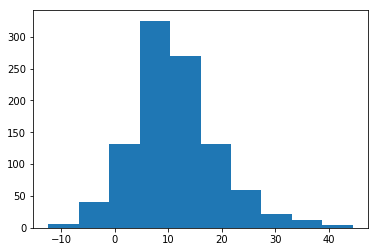

In [100]:
plt.hist([t[0] for t in thetas])

Now we are in a position to calculate:

   (i) for each school j, the probability that its coaching program is the best of the eight; and 
    
   (ii) for each pair of schools, j and k, the probability that the coaching program in school j is better than that in school k.

In [160]:
# Calculate the proportion of the simulation that each school was the best
best = np.zeros(8)
for sc in range(8):
    for theta in thetas:
        best[np.argmax(theta)] += 1
# normalize so that the sum adds to 1
best = best/best.sum()
print("School\t\tProbability that coaching program is best")
for ii, sc in enumerate(best):
    print("{0}\t\t{1}%".format("ABCDEFGH"[ii], np.around(sc*100, 1)))

School		Probability that coaching program is best
A		25.7%
B		12.3%
C		8.1%
D		10.3%
E		5.7%
F		6.7%
G		18.8%
H		12.4%


In [109]:
np.argmax(thetas[2])

6

In [161]:
for j in range(8):
    print("Probability that school {0}'s coaching program is better than that for school".format("ABCDEFGH"[j]))
    for k in range(0, 8):
        if j != k:
            print("\t{0}:\t{1}%"\
             .format("ABCDEFGH"[k], \
                     100.*sum([t[j] > t[k] for t in thetas])/len(thetas)))

Probability that school A's coaching program is better than that for school
	B:	63.4%
	C:	67.5%
	D:	65.7%
	E:	72.7%
	F:	68.9%
	G:	53.8%
	H:	62.2%
Probability that school B's coaching program is better than that for school
	A:	36.6%
	C:	56.4%
	D:	51.2%
	E:	61.4%
	F:	58.1%
	G:	38.5%
	H:	48.8%
Probability that school C's coaching program is better than that for school
	A:	32.5%
	B:	43.6%
	D:	44.4%
	E:	55.5%
	F:	50.8%
	G:	32.5%
	H:	44.1%
Probability that school D's coaching program is better than that for school
	A:	34.3%
	B:	48.8%
	C:	55.6%
	E:	60.4%
	F:	57.7%
	G:	37.2%
	H:	48.3%
Probability that school E's coaching program is better than that for school
	A:	27.3%
	B:	38.6%
	C:	44.5%
	D:	39.6%
	F:	43.5%
	G:	26.9%
	H:	37.1%
Probability that school F's coaching program is better than that for school
	A:	31.1%
	B:	41.9%
	C:	49.2%
	D:	42.3%
	E:	56.5%
	G:	31.2%
	H:	43.1%
Probability that school G's coaching program is better than that for school
	A:	46.2%
	B:	61.5%
	C:	67.5%
	D:	62.8%
	E:	73.1

(b)

With $\tau$ set to $\infty$ the conditional posterior distribution for $\hat{\theta}_{j}$s is no longer a function of $\mu$ or $\tau$, and equations (5.17) simplify to:

$\theta_{j}|y \sim \mathcal{N}(\bar{y}_{.j}, \sigma_j^{2})$.

In [170]:
thetas_b = []

In [171]:
for ii in range(1000):
    thetas_b.append([np.random.normal(loc=yjs[jj], scale=sigjs[jj]) \
                     for jj in range(8)])

In [174]:
# Calculate the proportion of the simulation that each school was the best
best = np.zeros(8)
for sc in range(8):
    for theta in thetas_b:
        best[np.argmax(theta)] += 1
# normalize so that the sum adds to 1
best = best/best.sum()
print("School\t\tProbability that coaching program is best")
for ii, sc in enumerate(best):
    print("{0}\t\t{1}%".format("ABCDEFGH"[ii], np.around(sc*100, 1)))

School		Probability that coaching program is best
A		56.9%
B		3.5%
C		2.9%
D		2.5%
E		0.0%
F		1.6%
G		17.3%
H		15.3%


In [175]:
for j in range(8):
    print("Probability that school {0}'s coaching program is better than that for school".format("ABCDEFGH"[j]))
    for k in range(0, 8):
        if j != k:
            print("\t{0}:\t{1}%"\
             .format("ABCDEFGH"[k], \
                     100.*sum([t[j] > t[k] for t in thetas_b])/len(thetas_b)))

Probability that school A's coaching program is better than that for school
	B:	86.6%
	C:	92.3%
	D:	87.7%
	E:	95.3%
	F:	91.8%
	G:	70.3%
	H:	77.5%
Probability that school B's coaching program is better than that for school
	A:	13.4%
	C:	72.1%
	D:	54.2%
	E:	76.8%
	F:	67.1%
	G:	23.1%
	H:	43.0%
Probability that school C's coaching program is better than that for school
	A:	7.7%
	B:	27.9%
	D:	29.4%
	E:	44.8%
	F:	41.7%
	G:	12.5%
	H:	27.1%
Probability that school D's coaching program is better than that for school
	A:	12.3%
	B:	45.8%
	C:	70.6%
	E:	71.7%
	F:	63.2%
	G:	20.9%
	H:	39.2%
Probability that school E's coaching program is better than that for school
	A:	4.7%
	B:	23.2%
	C:	55.2%
	D:	28.3%
	F:	41.7%
	G:	5.7%
	H:	25.1%
Probability that school F's coaching program is better than that for school
	A:	8.2%
	B:	32.9%
	C:	58.3%
	D:	36.8%
	E:	58.3%
	G:	12.8%
	H:	30.7%
Probability that school G's coaching program is better than that for school
	A:	29.7%
	B:	76.9%
	C:	87.5%
	D:	79.1%
	E:	94.3%
	F

The pairwise probabilities can be calculated analytically:

$Pr(\theta_{j} > \theta_{k}) = \frac{\Phi(\bar{y}_j - \bar{y}_k)}{\sqrt{\sigma_j^2 + \sigma_k^2}}$

In [176]:
from scipy.stats import norm

In [200]:
for j in range(8):
    print("Analytical probability that school {0}'s coaching program is better than that for school".format("ABCDEFGH"[j]))
    for k in range(0, 8):
        if j != k:
            print("\t{0}:\t{1:.1f}%"\
             .format("ABCDEFGH"[k], \
                     100.*norm.cdf((yjs[j]-yjs[k])/np.sqrt(sigjs[j]**2.+sigjs[k]**2.))))

Analytical probability that school A's coaching program is better than that for school
	B:	86.6%
	C:	92.1%
	D:	87.1%
	E:	95.1%
	F:	92.7%
	G:	71.0%
	H:	75.3%
Analytical probability that school B's coaching program is better than that for school
	A:	13.4%
	C:	72.0%
	D:	52.7%
	E:	74.8%
	F:	68.1%
	G:	24.0%
	H:	42.3%
Analytical probability that school C's coaching program is better than that for school
	A:	7.9%
	B:	28.0%
	D:	30.3%
	E:	45.7%
	F:	41.8%
	G:	13.3%
	H:	26.7%
Analytical probability that school D's coaching program is better than that for school
	A:	12.9%
	B:	47.3%
	C:	69.7%
	E:	71.3%
	F:	65.0%
	G:	23.0%
	H:	40.6%
Analytical probability that school E's coaching program is better than that for school
	A:	4.9%
	B:	25.2%
	C:	54.3%
	D:	28.7%
	F:	44.4%
	G:	7.9%
	H:	25.9%
Analytical probability that school F's coaching program is better than that for school
	A:	7.3%
	B:	31.9%
	C:	58.2%
	D:	35.0%
	E:	55.6%
	G:	12.6%
	H:	30.1%
Analytical probability that school G's coaching program is bet

(c)

The results for which $\tau$ was set to infinity make firmer conclusions on the basis of the data, e.g., in that case school A has a greater than 50% chance of being the best school outright, whereas in the case where a finite $\tau$ was included the corresponding probability is ~25%.  Similarly the probability that school E is the best is reduced by an order of magnitude when $\tau$ is set to infinity.

The hierarchical model in general reduces the "extreme" conclusions that the $\tau \rightarrow \infty$ model draw.

It is also possible for the pairwise comparisons to swap with respect to which is more likely to be the best.  See for example schools C and E; school C's program is predicted better than school E's for the hierarchichal model, whereas school E's is predicted better than C's for the $\tau \rightarrow \infty$ case.

(d)

At $\tau = 0$ the experiments are all inferred to have the same size effect, 7.7 points, and the same standard error, 4.1 points.

Hence there are degenerate values for the probabilities calculated above: 100%/8 = 12.5% probability that each school is the best overall, and 50% probability for the pairwise probabilities.

### 4. Exchangeable prior distributions
Suppose it is known a priori that the 2J parameters θ1 , . . . , θ2J are clustered into two groups, with exactly half being drawn from a N(1, 1) distribution, and the other half being drawn from a N(−1, 1) distribution, but we have not observed which parameters come from which distribution.

(a) Are θ1 , . . . , θ2J exchangeable under this prior distribution?

(b) Show that this distribution cannot be written as a mixture of independent and identically distributed components.

(c) Why can we not simply take the limit as J → ∞ and get a counter-example to de Finetti’s theorem?

(a)

Yes, the $\theta_{j}$ are exchangeable.  Since we don't know which of the individual $\theta_{j}$ belong to which of the two groups, exchanging any two of them will not alter the joint probability distribution.

(b)

The covariance of any pair $\theta_i, \theta_j$ is negative; if $\theta_i$ comes from the one distribution, the probability that $\theta_j$ comes from the other distribution is increased (since we know that initially there were exactly half in each group).  This implies that the $\theta_j$ cannot be written as a mixture of two i.i.d. distributions, as the covariance in that case would necessarily be greater than or equal to zero (see question 5 below).

(c)

If the size of the distrubution is increased to $J \rightarrow \infty$, the covariances between the $\theta_i, \theta_j \rightarrow 0$, which means that the joint distribution does approach i.i.d.  This can be understood as being a consequence of the fact that when the size of the two distributions are both infinite, it is no more likely that a the second picked $\theta_j$ comes from the other distribution with respect to the first.

### 5. Mixtures of independent distributions
Suppose the distribution of θ = (θ1, . . . , θJ ) can be written as a mixture of independent and identically distributed components:

$p(\theta) = \int \prod_{j=1}^J p(\theta_j|\phi)p(\phi)d\phi$

Prove that the covariances cov(θi,θj) are all nonnegative.

From equation (1.9), we have:
    
$cov(\theta_i, \theta_j) = E(cov(\theta_i, \theta_j | \phi)) + cov(E(\theta_i|\phi),E(\theta_j|\phi))$.

The $\theta_j$ are conditionally independent, so $E(cov(\theta_i, \theta_j | \phi)) = 0$.

Also, $E(\theta_i|\phi) = E(\theta_j|\phi) = \mu(\phi)$, say.

So 

$cov(\theta_i, \theta_j) = cov(\mu(\phi), \mu(\phi)) = var(\mu(\phi))$.

This quantity must be $\geq 0$, since variance cannot be negative.

### 7. Continuous mixture models

(a) If y|θ ∼ Poisson(θ), and θ ∼ Gamma(α,β), then the marginal (prior predictive) distribution of y is negative binomial with parameters α and β (or p = β/(1 + β)). Use the formulas (2.7) and (2.8) to derive the mean and variance of the negative binomial.


(b) In the normal model with unknown location and scale (μ,σ2), the noninformative prior density, p(μ, σ2) ∝ 1/σ2, results in a normal-inverse-χ2 posterior distribution for (μ, σ2).

Marginally then $\sqrt{n}(\mu - \bar{y})/s$ has a posterior distribution that is $t_{n-1}$.

Use  (2.7) and (2.8) to derive the first two moments of the latter distribution, stating the appropriate condition on n for existence of both moments.

(a) 

The mean and binomial of the negative binomial are:

$E(\theta) = \frac{\alpha}{\beta}$,

var$(\theta) = \frac{\alpha}{\beta^2}(\beta+1)$.

Formulas (2.7) and (2.8) are (switching the $y$ and $\theta$ variables):

$E(y) = E(E(y|\theta))$,

$var(y) = E(var(y|\theta)) + var(E(y|\theta))$.

$y|\theta \sim Poisson(\theta) \implies P(y|\theta)=\frac{\theta^ye^{-\theta}}{y!}$, which has mean and variance both equal to $\theta$, i.e., both $E(y|\theta)$ and $var(y|\theta)$ are equal to $\theta$.

So 

$E(y) = E(\theta) = E(Gamma(\alpha, \beta)) = \frac{\alpha}{\beta}$, and

$var(y) = E(\theta) + var(\theta) = E(Gamma(\alpha, \beta)) + var(Gamma(\alpha, \beta)) = \frac{\alpha}{\beta} + \frac{\alpha}{\beta^2} = \frac{\alpha}{\beta^2}(\beta+1)$

(b)

The form of the $t_\nu$ distribution is:

$p(\theta) = \frac{\Gamma((\nu+1)/2)}{\Gamma(\nu/2)\sqrt{\nu\pi\sigma}}(1+\frac{1}{\nu}(\frac{\theta-\mu}{\sigma})^2)^{-(\nu+1)/2}$, so that

$p(\sqrt{n}(\mu - \bar{y})/s|\sigma^2, y) = \frac{\Gamma(n/2)}{\Gamma((n-1)/2)\sqrt{(n-1)\pi\sigma}}(1+\frac{1}{n-1}(\frac{(\sqrt{n}(\mu - \bar{y})/s)-\mu}{\sigma})^2)^{-n/2}$,

where we are conditioning on $\sigma^2$ per (3.3), and treating $\bar{y}$, $s$, and $n$ as constants.

(2.7) then gives us that

$E(\sqrt{n}(\mu - \bar{y})/s|y) = E(E(\sqrt{n}(\mu - \bar{y})/s|\sigma^2, y)|y) = E((\sqrt{n}/s)E(\mu-\bar{y}|\sigma^2, y)|y) = E((\sqrt{n}/s)\times0)|y) = E(0|y) = 0.$

for $n-1>1$, i.e., for $n>2$.

(2.8) gives us that

$var(\sqrt{n}(\mu-\bar{y})/s|y) = E(var(\sqrt{n}(\mu-\bar{y})/s|\sigma^2, y)|y) + var(E(\sqrt{n}(\mu-\bar{y})/s|\sigma^2, y)|y) = E(var(\sqrt{n}(\mu-\bar{y})/s|\sigma^2, y)|y),$

since $var(E(\sqrt{n}(\mu-\bar{y})/s|\sigma^2, y)|y) = 0$.

Since

$var(AX + B) = A^2 var X$ for random variable $X$,

We have that

$E(var(\sqrt{n}(\mu-\bar{y})/s|\sigma^2, y)|y) = $
$E(n/s^2var(\mu|\sigma^2, y)|y),$

which, using (3.3) is

$E(n/s^2\sigma^2/n|y) = E(\sigma^2/s^2|y) = E(\sigma^2|y)/s^2.$

(3.5) tells us that 

$\sigma^2|y \sim Inv-\chi^2(n-1, s^2)$, meaning

$var(\sqrt{n}(\mu-\bar{y})/s|y) = 1/s^2 E(Inv-\chi^2(n-1, s^2)),$

which from Appendix A we know is

$1/s^2\frac{n-1}{n-3}s^2 = \frac{n-1}{n-3}$.

This must have $n \gt 3$ to be defined.

### 8. Discrete mixture models

If pm(θ), for m = 1,...,M, are conjugate prior densities for the sampling model y|θ, show that the class of finite mixture prior densities given by

$P(\theta) = \sum_{m=1}^{M}\lambda_mP_m(\theta)$

is also a conjugate class, where the λm’s are nonnegative weights that sum to 1. This can provide a useful extension of the natural conjugate prior family to more flexible distributional forms. As an example, use the mixture form to create a bimodal prior density for a normal mean, that is thought to be near 1, with a standard deviation of 0.5, but has a small probability of being near −1, with the same standard deviation. If the variance of each observation y1, . . . , y10 is known to be 1, and their observed mean is y = −0.25, derive your posterior distribution for the mean, making a sketch of both prior and posterior densities. Be careful: the prior and posterior mixture proportions are different.

We have that

$p_m(\theta|y) = \frac{p_m(\theta)p(y|\theta)}{p_m(y)},$

where $p_m(y)$ is the prior predictive distribution for the prior $p_m(\theta)$.

So

$p(\theta|y) \propto \sum_m \lambda_m p_m(\theta) p(y|\theta)$

$= \sum_m \lambda_m p_m(y) p_m(\theta|y),$

i.e., the posterior distribution is proportional to a sum of the $m$ posterior distributions associated with the priors $p_m(\theta)$, with weights given by the products of the $\lambda_m$ weights and the prior predictive distributions.

Since the $p_m(\theta)$ were all conjugate, this shows that the prior defined as their mixture is also conjugate, producing a posterior which is a mixture of the m corresponding posteriors.

Bimodal prior density with 90% chance of having mean 1, and 10% chance of having mean -1:

$\theta \sim 0.9\mathcal{N}(1, 0.5) + 0.1\mathcal{N}(-1, 0.5)$

In [8]:
p1_samples = np.random.normal(loc=1., scale=0.5, size=900)
p2_samples = np.random.normal(loc=-1., scale=0.5, size=100)

In [10]:
mixture_samples = list(p1_samples) + list(p2_samples)

{'bodies': [<matplotlib.collections.PolyCollection at 0x7fbdec4b7dd8>],
 'cmaxes': <matplotlib.collections.LineCollection at 0x7fbdec4c1c50>,
 'cmins': <matplotlib.collections.LineCollection at 0x7fbdec4d73c8>,
 'cbars': <matplotlib.collections.LineCollection at 0x7fbdec4d77f0>}

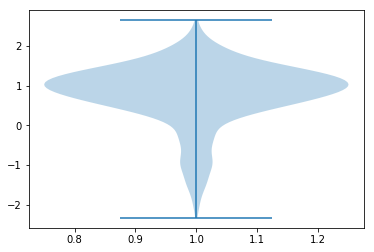

In [14]:
plt.violinplot(mixture_samples)

In [15]:
mu1 = 1.; mu2 = -1.; std = 0.5

In [16]:
def mixdens(mu1, mu2, std, x, props):
    dens = props[0]*1./(np.sqrt(2*np.pi)*std) * \
            np.exp(-(x-mu1)**2./(2.*std**2.)) + \
            props[1]*1./(np.sqrt(2*np.pi)*std) * \
             np.exp(-(x-mu2)**2./(2.*std**2.))
    return dens

In [22]:
xs = np.linspace(-2., 2.5, 2000)
ys = [mixdens(mu1, mu2, std, x, [0.9, 0.1]) for x in xs]

### Prior Density:

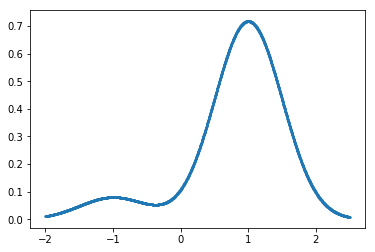

In [25]:
plt.scatter(xs, ys, s=2)

### Data:

We have 10 observations, with sample mean -0.25 and sample variance 1.  The prior predictive distributions for this data are:

In [30]:
def Ndens(mu, var, y):
    return 1./(np.sqrt(2*np.pi*var)) * np.exp(-(1./2./var)*(y-mu)**2.)

In [31]:
ybar = -.25; vary = 1./10
mu1 = 1.
mu2 = -1.

In [36]:
print("p_1(y): {0:.4f}".format(Ndens(mu1, (1./2.)**2.+vary, ybar)))
print("p_2(y): {0:.4f}".format(Ndens(mu2, (1./2.)**2.+vary, ybar)))

p_1(y): 0.0724
p_2(y): 0.3019


(2.11) gives us that:

$P(\theta|y) = \mathcal{N}(\theta|\mu_n, \tau_n^2),$

with

$\mu_n = \frac{\frac{1}{\tau_0^2}\mu_0+\frac{n}{\sigma^2}\bar{y}}{\frac{1}{\tau_0^2}+\frac{n}{\sigma^2}}$ and 
$\frac{1}{\tau_n^2} = \frac{1}{\tau_0^2} + \frac{n}{\sigma^2}.$

So, with $\bar{y} = -0.25,$ and $\sigma^2 = 1,$ and $\tau_0^2 = 0.5^2,$

In [39]:
var = 1.; tau_0 = 0.5; n = 10

In [40]:
mu_n_1 = (1./tau_0**2*mu1+n/var*ybar)/(1./tau_0**2 + n/var)

In [42]:
mu_n_2 = (1./tau_0**2*mu2+n/var*ybar)/(1./tau_0**2 + n/var)

In [44]:
tau_n_1 = 1./(1./tau_0**2 + n/var)
tau_n_2 = 1./(1./tau_0**2 + n/var)

In [59]:
print("mu_n_1 = {0:.4f}".format(mu_n_1))
print("mu_n_2 = {0:.4f}".format(mu_n_2))
print("tau_n_1^2 = {0:.4f}".format(tau_n_1))
print("tau_n_2^2 = {0:.4f}".format(tau_n_2))

mu_n_1 = 0.1071
mu_n_2 = -0.4643
tau_n_1^2 = 0.0714
tau_n_2^2 = 0.0714


Our posterior weights must sum to one, so that the individual weights are:

$\frac{\lambda_m p_k(y)}{\sum_k \lambda_k p_k(y)},$

giving

$\frac{0.9 \cdot 0.0724}{0.9 \cdot 0.0724 + 0.1 \cdot 0.3019} = 0.683$

and

$\frac{0.1 \cdot 0.3019}{0.9 \cdot 0.0724 + 0.1 \cdot 0.3019} = 0.312.$

So that

$p(\theta|y) = 0.683 \mathcal{N}(\theta|0.1071, 0.0714) + 
               0.312 \mathcal{N}(\theta|-0.4643, 0.0714).$

### Posterior Density:

In [61]:
xs = np.linspace(-2., 2.5, 2000)
ys = [mixdens(0.1071, -0.4643, np.sqrt(0.0714), x, [0.683, 0.312]) for x in xs]

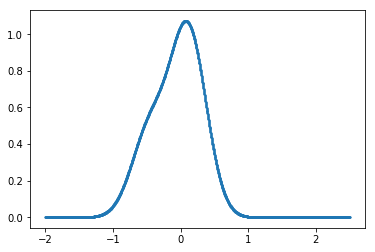

In [62]:
plt.scatter(xs, ys, s=2)